In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import splitfolders
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Define paths and constants
base_dir = "/content/drive/MyDrive/trash_images"
output_folder = '/content/drive/MyDrive/trash_images_split'
model_save_path = '/content/drive/MyDrive/trash_ai_model.h5'  # replace with where you want to save the model


In [16]:
# Split the data
splitfolders.ratio(base_dir, output=output_folder, seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 1799 files [01:12, 24.65 files/s]


In [6]:
train_dir = os.path.join(output_folder, 'train')
val_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

In [7]:
batch_size = 32
img_size = (720, 1280)  # height x width

# Create a data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load the base model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=img_size + (3,))


29084464/29084464 [==============================] - 2s 0us/step


In [8]:
# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(5, activation='softmax')(x)  # we have 5 classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [9]:
# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Train the model
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10)  # adjust the number of epochs according to your requirement

Found 1436 images belonging to 5 classes.
Found 178 images belonging to 5 classes.


<ipython-input-10-7e73f035d88a>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/10
44/44 [==============================] - 1378s 30s/step - loss: 16.8617 - accuracy: 0.7714 - val_loss: 3.8938 - val_accuracy: 0.9438
Epoch 2/10
44/44 [==============================] - 109s 2s/step - loss: 0.6652 - accuracy: 0.9736 - val_loss: 1.7788 - val_accuracy: 0.9438
Epoch 3/10
44/44 [==============================] - 109s 2s/step - loss: 0.2204 - accuracy: 0.9893 - val_loss: 2.0772 - val_accuracy: 0.9625
Epoch 4/10
44/44 [==============================] - 99s 2s/step - loss: 0.5068 - accuracy: 0.9801 - val_loss: 2.3728 - val_accuracy: 0.9688
Epoch 5/10
44/44 [==============================] - 108s 2s/step - loss: 0.1342 - accuracy: 0.9907 - val_loss: 1.8701 - val_accuracy: 0.9688
Epoch 6/10
44/44 [==============================] - 107s 2s/step - loss: 0.2150 - accuracy: 0.9915 - val_loss: 2.9189 - val_accuracy: 0.9375
Epoch 7/10
44/44 [==============================] - 109s 2s/step - loss: 0.1629 - accuracy: 0.9922 - val_loss: 3.1100 - val_accuracy: 0.9563
Epoch 8/10


In [12]:
# Save the model
model.save(model_save_path)

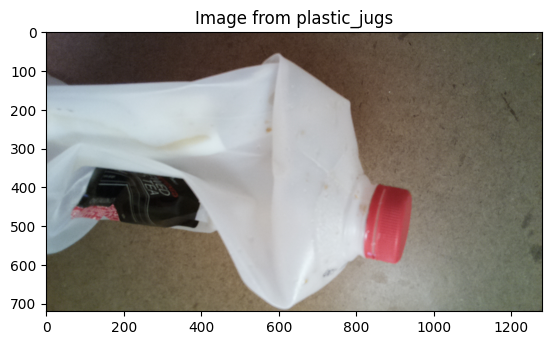

1/1 [==============================] - 0s 53ms/step
Predicted for plastic_jugs: [[0. 0. 0. 0. 1.]]


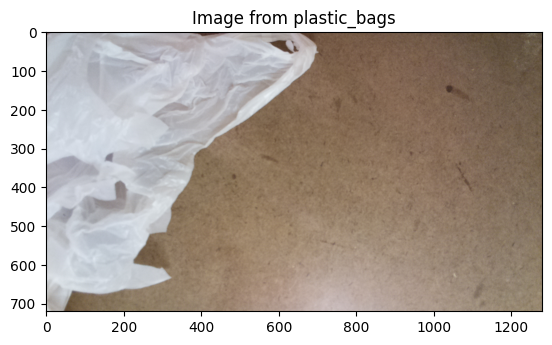

1/1 [==============================] - 0s 62ms/step
Predicted for plastic_bags: [[0. 0. 1. 0. 0.]]


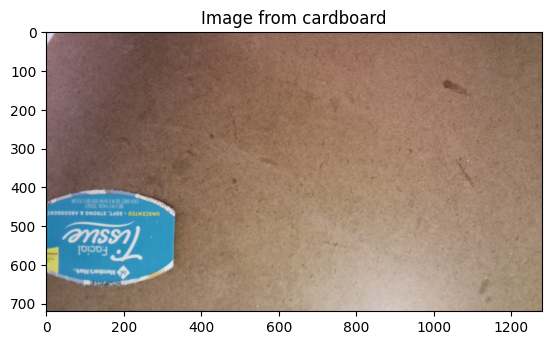

1/1 [==============================] - 0s 57ms/step
Predicted for cardboard: [[1.7221316e-32 1.0000000e+00 0.0000000e+00 3.3092905e-18 0.0000000e+00]]


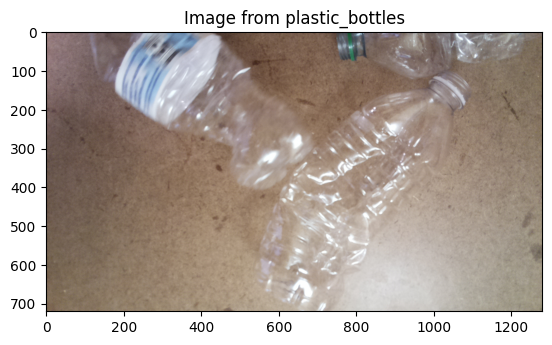

1/1 [==============================] - 0s 80ms/step
Predicted for plastic_bottles: [[0. 0. 0. 1. 0.]]


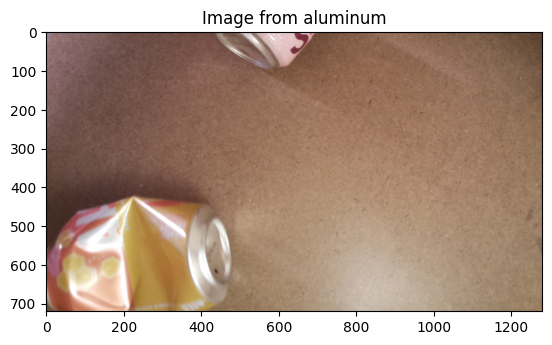

1/1 [==============================] - 0s 38ms/step
Predicted for aluminum: [[1. 0. 0. 0. 0.]]


In [16]:
import matplotlib.pyplot as plt

# get list of subdirectories
subdirs = os.listdir(test_dir)

# loop over each subdirectory (i.e., each class)
for subdir in subdirs:
    subdir_path = os.path.join(test_dir, subdir)
    test_image_paths = os.listdir(subdir_path)
    np.random.shuffle(test_image_paths)
    test_image_paths = test_image_paths[:1]  # choose 1 random image from each class

    for test_image_path in test_image_paths:
        img = image.load_img(os.path.join(subdir_path, test_image_path), target_size=img_size)

        # Display the image
        plt.figure()
        plt.imshow(img)
        plt.title(f'Image from {subdir}')
        plt.show()

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x /= 255.  # same scaling as in the data generator

        preds = model.predict(x)
        print(f'Predicted for {subdir}:', preds)

In [17]:
from sklearn.metrics import classification_report

# Define the ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Get the true labels from the test set
y_true = test_generator.classes

# Predict probabilities for the test set
y_pred_probs = model.predict_generator(test_generator, steps=test_generator.samples // batch_size + 1)

# Get the predicted classes
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute and print the classification report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print(report)

Found 185 images belonging to 5 classes.


<ipython-input-17-5bdff1e706b3>:18: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_probs = model.predict_generator(test_generator, steps=test_generator.samples // batch_size + 1)


                 precision    recall  f1-score   support

       aluminum       0.97      1.00      0.99        71
      cardboard       0.86      0.96      0.91        26
   plastic_bags       1.00      0.90      0.95        20
plastic_bottles       1.00      0.98      0.99        46
   plastic_jugs       0.90      0.82      0.86        22

       accuracy                           0.96       185
      macro avg       0.95      0.93      0.94       185
   weighted avg       0.96      0.96      0.96       185

